Set-up librerias

In [ ]:
# pandas to open data files & processing it.
import pandas as pd
# to see all columns
pd.set_option('display.max_columns', None)


# numpy for numeric data processing
import numpy as np

# keras for deep learning model creation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

# Regular Expression for text cleaning
import re

# to track the progress - progress bar
from tqdm.notebook import tqdm

Read dataset

In [ ]:
sarcasm_data = pd.read_csv("train-balanced-sarcasm.csv")
print(sarcasm_data.shape)

(1010826, 10)


Drop columns unused

In [ ]:
sarcasm_data.drop(['author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment'], axis=1, inplace=True)
# remove empty rows
sarcasm_data.dropna(inplace=True)
# dropping empty comment entries

sarcasm_data.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


In [ ]:
sarcasm_data['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

Preprocessing dataset (remove contractions, fix spaces, to lowercase)

In [ ]:
mispell_dict = {"ain't": "is not", "cannot": "can not", "aren't": "are not", "can't": "can not", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",
                "doesn't": "does not",
                "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did",
                "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am",
                "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would",
                "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would",
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
                "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
                "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "wont": "will not", "won't've": "will not have", "would've": "would have",
                "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color',
                'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor',
                'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What',
                'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I',
                'theBest': 'the best', 'howdoes': 'how does', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what',
                'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

mispell_dict = {k.lower(): v.lower() for k, v in mispell_dict.items()}

In [ ]:
def preprocessing_text(s):
    # making our string lowercase & removing extra spaces
    s = str(s).lower().strip()
    
    # remove contractions.
    s = " ".join([mispell_dict[word] if word in mispell_dict.keys() else word for word in s.split()])
    
    # removing \n
    s = re.sub('\n', '', s)
    
    # put spaces before & after punctuations to make words seprate. Like "king?" to "king", "?".
    s = re.sub(r"([?!,+=—&%\'\";:¿।।।|\(\){}\[\]//])", r" \1 ", s)
    
    # Remove more than 2 continues spaces with 1 space.
    s = re.sub('[ ]{2,}', ' ', s).strip()
    
    return s

In [ ]:
# apply preprocessing_text function
sarcasm_data['comment'] = sarcasm_data['comment'].apply(preprocessing_text)
sarcasm_data.head()

,label,comment
0,0,nc and nh.
1,0,you do know west teams play against west teams...
2,0,"they were underdogs earlier today , but since ..."
3,0,"this meme is not funny none of the "" new york ..."
4,0,i could use one of those tools.


Prepare matrix embedded for layer to identify relations between words

In [ ]:
# total unique words we are going to use.
TOTAL_WORDS = 40000

# max number of words one sentence can have
MAX_LEN = 50

# width of of 1D embedding vector
EMBEDDING_SIZE = 300

In [ ]:
tokenizer = Tokenizer(num_words=TOTAL_WORDS)
tokenizer.fit_on_texts(list(sarcasm_data['comment']))

train_data = tokenizer.texts_to_sequences(sarcasm_data['comment'])
train_data = pad_sequences(train_data, maxlen = MAX_LEN)
target = sarcasm_data['label']


In [ ]:
print(str(tokenizer.index_word)[0:500])

{1: 'the', 2: 'is', 3: 'a', 4: 'to', 5: 'i', 6: 'you', 7: 'not', 8: 'it', 9: 'and', 10: 'that', 11: 'of', 12: 'in', 13: 'are', 14: 'for', 15: 'have', 16: 'but', 17: 'they', 18: 'this', 19: 'be', 20: 'do', 21: 'on', 22: 'he', 23: 'so', 24: 'just', 25: 'was', 26: 'with', 27: 'like', 28: "'", 29: 'can', 30: 'if', 31: 'would', 32: 'because', 33: 'all', 34: 'we', 35: 'what', 36: 'will', 37: 'as', 38: 'no', 39: 'your', 40: 'my', 41: 'yeah', 42: 'at', 43: 'am', 44: 'people', 45: 'get', 46: 'or', 47: 'a


In [ ]:

EMBEDDING_FILE = 'crawl-300d-2M.vec'

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in tqdm(open(EMBEDDING_FILE,encoding="utf8")))

word_index = tokenizer.word_index
nb_words = min(TOTAL_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_SIZE))

In [ ]:
for word, i in tqdm(word_index.items()):
    if i >= TOTAL_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(40000, 300)

Make NLP model

In [ ]:
lstm_model=Sequential()
input_layer = Input(shape=(MAX_LEN,))
lstm_model.add(input_layer)
embedding_layer = Embedding(TOTAL_WORDS, EMBEDDING_SIZE, weights = [embedding_matrix])
lstm_model.add(embedding_layer)
LSTM_layer = Bidirectional(LSTM(128, return_sequences = True))
lstm_model.add(LSTM_layer)

maxpool_layer = GlobalMaxPool1D()
lstm_model.add(maxpool_layer)
dense_layer_1 = Dense(64, activation="relu")
lstm_model.add(dense_layer_1)
dropout_1 = Dropout(0.5)
lstm_model.add(dropout_1)

dense_layer_2 = Dense(32, activation="relu")
lstm_model.add(dense_layer_2)
dropout_2 = Dropout(0.5)
lstm_model.add(dropout_2)

output_layer = Dense(1, activation="sigmoid")
lstm_model.add(output_layer)



lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           12000000  
                                                                 
 bidirectional (Bidirectiona  (None, 50, 256)          439296    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2

Training model

In [ ]:
BATCH_SIZE = 512
EPOCHS = 2

history = lstm_model.fit(
    train_data, target,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    # We are using randomly selected 20% sentences as validation data.
    validation_split=0.2
)

Epoch 1/2
1580/1580 [==============================] - 1736s 1s/step - loss: 0.5677 - accuracy: 0.7084 - val_loss: 0.5230 - val_accuracy: 0.7374
Epoch 2/2
1580/1580 [==============================] - 1799s 1s/step - loss: 0.5214 - accuracy: 0.7445 - val_loss: 0.5183 - val_accuracy: 0.7413


In [ ]:
sarcasm_data[sarcasm_data['label']==1].sample(20)

,label,comment
596282,1,"but it says that on market lol , it must be wo..."
611779,1,"well , you can charge it via the lightning port !"
959918,1,nope.
268389,1,so much room beneath the name for ads
824933,1,damn i bet this dude is rollin in pussy
168067,1,yeah because conservatives are completely inno...
132204,1,it is because they are not the elect.
284836,1,just sell your cell will have money then.
931120,1,........hes got a point you know.
225373,1,yeah but the pressure is off lescott now so he...


In [ ]:
sentence = "this is not gonna have any problem, dummy"
sentence = preprocessing_text(sentence)
print(sentence)

sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen = MAX_LEN)

this is not gonna have any problem , dummy


In [ ]:
prediction = lstm_model.predict(sentence)
print("So, it's saying sentence have probability of %.3f percent"%(prediction[0][0]*100))

So, it's saying sentence have probability of 66.624 percent


In [ ]:
from sklearn.model_selection import train_test_split
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(train_data, target, test_size=0.33)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
y_test_pred = lstm_model.predict(X_test_lstm)
y_test_pred = np.round(y_test_pred).astype(int)

test_acc_lstm = accuracy_score(y_test_lstm,y_test_pred)
print('Test accuracy of lstm: ', test_acc_lstm)

Test accuracy of lstm:  0.7688004413052081


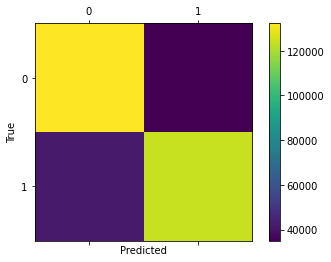

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test_lstm, y_test_pred)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

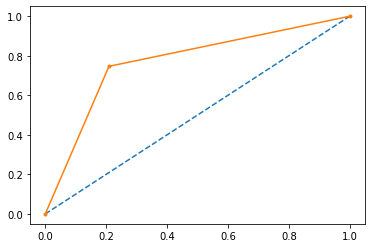

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test_lstm, y_test_pred)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, bag_reg_svm_pred)
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')
# show the plot
plt.show()

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, bag_reg_svm_pred)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

NameError: ignored